# Google POI Confidence

The primary aim of this notebook is to calculate the confidence interval of Google'S POI which was scrape from google maps. The confidence interval will be calculated with respect to OSM POI.

In [1]:
# importing all neccesary libraries
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

In [2]:
# loading datasets
google_poi = pd.read_csv('./data/google_poi.csv', delimiter=";");
osm_poi = pd.read_csv('./data/osm_poi.csv', delimiter=";");
match_poi = pd.read_csv('./data/google_osm_poi_matching.csv', delimiter=";");

/home/eteims/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Exploring the datasets

There three dataset which were all gotten from Kuwala's pipeline
1. Google POI dataset: This contains all the point of interest data gotten from Google maps.
2. OSM POI dataset: This contains point of interest from OpenStreetMap for a given area.
3. Match POI dataset: contains both google POI and OSM POI data which will be used to measure the confidence.

In [3]:
google_poi.head()

,internal_id,h3_index,latitude,longitude,name,tags,categories,place_id,address,timezone,...,price_level,contact_phone,contact_website,number_of_reviews,rating_stars,spending_time_min,spending_time_max,has_popularity,has_opening_hours,has_waiting_time
0,0x46b54a5a7d4ed1fd:0x932ad74a3f2e7e60,8f1181a1952d630,55.410307,37.902451,Moscow Domodedovo Mikhail Lomonosov Airport,{international_airport},{airport},ChIJ_dFOfVpKtUYRYH4uP0rXKpM,"{Moscow Oblast,Russia}",Europe/Moscow,...,NaN,7.495934e+10,https://www.dme.ru/,39373.0,4.2,NaN,NaN,True,False,True
1,0x487604e08939064d:0x59887c6e6e215e84,8f194ad1448cac9,51.493147,-0.137534,RE/MAX Central,"{real_estate_agents,apartment_rental_agency,co...",{service},ChIJTQY5ieAEdkgRhF4hbm58iFk,"{85 Rochester Row,London,SW1P 1LJ,United Kingdom}",Europe/London,...,NaN,4.420763e+11,http://www.remax.co.uk/central,111.0,4.5,NaN,NaN,False,True,False
2,0x48693091a4e3367d:0x4b05e135f5c25f78,8f195a413c021b2,51.674043,-4.908637,Pembroke,NaN,NaN,ChIJfTbjpJEwaUgReF_C9TXhBUs,{UK},Europe/London,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
3,0x47c5e37e3bef4933:0xb5e624f5197f65bf,8f1968269bb56cd,52.389700,4.849450,Black Cat Theatre,"{childrens_theater,music_school}","{art_culture,education}",ChIJM0nvO37jxUcRv2V_GfUk5rU,"{Schakelstraat 2,1014 AW Amsterdam,Netherlands}",Europe/Amsterdam,...,NaN,3.163807e+10,http://blackcattheatre.nl/,60.0,4.9,NaN,NaN,True,False,True
4,0x47c0c4973b395b15:0xbc45fd9317e81195,8f1fa096b432218,50.970247,5.680179,GO! basisschool voor buitengewoon onderwijs Mi...,{elementary_school},{misc},ChIJFVs5O5fEwEcRlRHoF5P9Rbw,"{Bosweg 71,3630 Maasmechelen,Belgium}",Europe/Brussels,...,NaN,3.289760e+09,http://www.bsbomikado.be/,5.0,4.8,NaN,NaN,False,True,False


In [4]:
google_poi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809 entries, 0 to 808
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   internal_id         809 non-null    object 
 1   h3_index            809 non-null    object 
 2   latitude            809 non-null    float64
 3   longitude           809 non-null    float64
 4   name                809 non-null    object 
 5   tags                729 non-null    object 
 6   categories          729 non-null    object 
 7   place_id            809 non-null    object 
 8   address             809 non-null    object 
 9   timezone            809 non-null    object 
 10  temporarily_closed  809 non-null    bool   
 11  permanently_closed  809 non-null    bool   
 12  inside_of           25 non-null     object 
 13  price_level         144 non-null    float64
 14  contact_phone       648 non-null    float64
 15  contact_website     514 non-null    object 
 16  number_o

In [5]:
# statistical info
google_poi.describe()

,latitude,longitude,price_level,contact_phone,number_of_reviews,rating_stars,spending_time_min,spending_time_max
count,809.000000,809.000000,144.000000,6.480000e+02,682.000000,682.000000,275.000000,275.000000
mean,36.078588,10.699027,1.756944,3.752324e+10,458.391496,4.323900,33.163636,62.327273
std,1.446164,21.930062,0.557799,3.219427e+10,1778.783623,0.598947,32.992348,55.413527
min,30.536637,-123.365644,1.000000,3.289760e+09,1.000000,1.000000,10.000000,10.000000
25%,35.891817,14.424416,1.000000,3.562138e+10,14.000000,4.200000,15.000000,15.000000
50%,35.899752,14.479313,2.000000,3.562166e+10,74.500000,4.500000,20.000000,45.000000
75%,35.918933,14.501429,2.000000,3.562755e+10,410.000000,4.700000,30.000000,90.000000
max,55.410307,37.902451,4.000000,5.261617e+11,39373.000000,5.000000,210.000000,240.000000


The OSM dataset is quite large and has some irrevelant data that are not usefully for this analysis. So it will be filtered.

In [6]:
osm_poi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37997 entries, 0 to 37996
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   osm_type                     37997 non-null  object 
 1   osm_id                       37997 non-null  int64  
 2   h3_index                     37997 non-null  object 
 3   latitude                     37997 non-null  float64
 4   longitude                    37997 non-null  float64
 5   name                         6860 non-null   object 
 6   tags                         37997 non-null  object 
 7   categories                   29058 non-null  object 
 8   address_house_nr             844 non-null    object 
 9   address_street               1462 non-null   object 
 10  address_zip_code             502 non-null    object 
 11  address_city                 844 non-null    object 
 12  address_country              136 non-null    object 
 13  address_full    

In [7]:
# filtering OSM POI dataset
relevant_osm_poi = osm_poi[osm_poi["osm_id"].isin(match_poi["osm_id"])]
relevant_osm_poi = relevant_osm_poi.set_index(pd.Index(np.arange(len(relevant_osm_poi))))

In [8]:
relevant_osm_poi.head()

,osm_type,osm_id,h3_index,latitude,longitude,name,tags,categories,address_house_nr,address_street,...,address_details_flats,address_details_unit,phone,email,website,brand,operator,boundary,admin_level,type
0,node,4695528889,8f3f3040020806c,35.966313,14.356234,Seashell Diving Centre,"{name=Seashell Diving Centre,amenity=school,na...",{education},NaN,Triq il-Marfa,...,NaN,NaN,NaN,NaN,NaN,NaN,Mr Hubert Borg,NaN,NaN,NaN
1,way,388179870,8f3f30400208443,35.966152,14.356059,Tunnynet,"{name=Tunnynet,building=retail,addr:city=Il-Me...",{shopping},NaN,Triq il-Marfa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,way,422428405,8f3f30400a86331,35.972256,14.349802,Munchies Mellieha Bay,"{name=Munchies Mellieha Bay,amenity=restaurant...","{food,misc}",NaN,Triq il-Marfa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,way,778983958,8f3f3040173424c,35.965233,14.371917,NaN,"{building=house,addr:city=Il-Mellieħa,addr:str...",{apartment},19,Triq J Kepler,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node,464766507,8f3f3040384acde,35.957381,14.362268,Bank of Valletta,"{addr:city=Mellieħa,addr:housenumber=34,addr:p...",{service},34,Triq Ġorġ Borg Olivier,...,NaN,NaN,NaN,NaN,NaN,NaN,Bank of Valletta plc,NaN,NaN,NaN


In [9]:
relevant_osm_poi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 809 entries, 0 to 808
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   osm_type                     809 non-null    object 
 1   osm_id                       809 non-null    int64  
 2   h3_index                     809 non-null    object 
 3   latitude                     809 non-null    float64
 4   longitude                    809 non-null    float64
 5   name                         724 non-null    object 
 6   tags                         809 non-null    object 
 7   categories                   809 non-null    object 
 8   address_house_nr             242 non-null    object 
 9   address_street               695 non-null    object 
 10  address_zip_code             192 non-null    object 
 11  address_city                 484 non-null    object 
 12  address_country              50 non-null     object 
 13  address_full        

In [10]:
# statistical info 
relevant_osm_poi.describe()

,osm_id,latitude,longitude,address_full,address_region_neighborhood,address_region_suburb,address_region_district,address_region_province,address_region_state,address_details_level,address_details_flats,address_details_unit,admin_level
count,8.090000e+02,809.000000,809.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
mean,3.547976e+09,35.911434,14.455878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,NaN
std,2.690310e+09,0.046190,0.073244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.263474e+07,35.819935,14.197847,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,NaN
25%,5.129990e+08,35.891236,14.433333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,NaN
50%,3.566311e+09,35.898943,14.483379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,NaN
75%,5.929202e+09,35.915128,14.503172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,NaN
max,7.891275e+09,36.080524,14.569744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,NaN


Exploring the match poi dataset.

In [11]:
match_poi.head()

,osm_type,osm_id,internal_id,query
0,way,154470603,0x130e44cd6e20475f:0x671441b8dc03be60,Kalkara
1,node,5896564791,0x130e45014da2fa03:0xf743a120b9194c06,"Spar, Triq Tigné"
2,node,2471609507,0x130e4501edfb329b:0x9edcdba888218c47,"Bayview Hotel & Apartments, The Strand 143, Sl..."
3,node,6222651588,0x130e450a6e7438bd:0x5af47e8f69212d52,"David Hardware Store, Triq Carlo Manche"
4,node,6635172974,0x130e451ad5f0c673:0x1973502978d5c025,"Chef Lee, Triq d'Argens"


In [12]:
match_poi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809 entries, 0 to 808
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   osm_type     809 non-null    object
 1   osm_id       809 non-null    int64 
 2   internal_id  809 non-null    object
 3   query        809 non-null    object
dtypes: int64(1), object(3)
memory usage: 25.4+ KB


## Visualization

The point of interests are coordinates so to get a better undrstanding of them we will visualize them on a map.

In [13]:
# creating a bounding box
BBox4osm =  (relevant_osm_poi.longitude.min(), relevant_osm_poi.longitude.max(),      
         relevant_osm_poi.latitude.min(), relevant_osm_poi.latitude.max())

In [14]:
BBox4osm

(14.1978473, 14.5697441101074, 35.8199353, 36.0805244445801)

In [15]:
osm_map = plt.imread('./assets/osm.png')

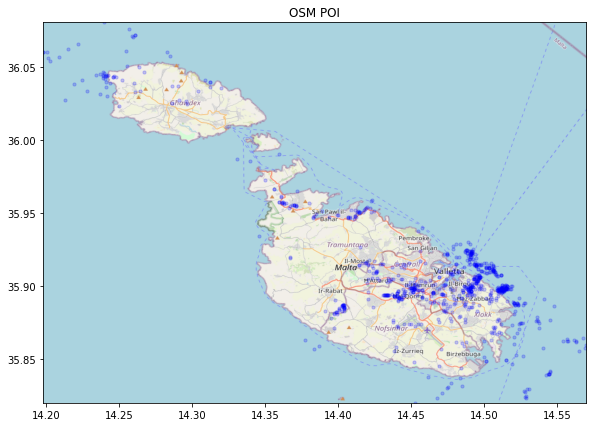

In [16]:
fig, ax = plt.subplots(figsize = (15,7))

ax.scatter(relevant_osm_poi.longitude, relevant_osm_poi.latitude, zorder=1, alpha = 0.2 ,c='b', s=10)
ax.set_title('OSM POI')
ax.set_xlim(BBox4osm[0],BBox4osm[1])
ax.set_ylim(BBox4osm[2],BBox4osm[3])
ax.imshow(osm_map, zorder=0, extent = BBox4osm, aspect= 'equal')

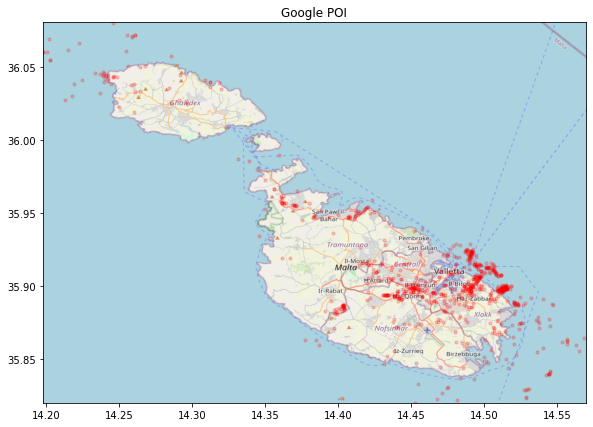

In [17]:
fig, ax = plt.subplots(figsize = (15, 7))
ax.scatter(google_poi.longitude, google_poi.latitude, zorder=1, alpha = 0.2, c='r', s=10)
ax.set_title('Google POI')
ax.set_xlim(BBox4osm[0],BBox4osm[1])
ax.set_ylim(BBox4osm[2],BBox4osm[3])
ax.imshow(osm_map, zorder=0, extent = BBox4osm, aspect= 'equal')

# Calculating the distance

Both maps data points look the same but we are not certain of their accuracy. The best approach is to calculate the distance between two corresponding POI. 

In [18]:
# adding longitude and lattitude to the match dataset.
match_poi["google_latitude"] = pd.Series(np.zeros(len(match_poi)))
match_poi["google_longitude"] = pd.Series(np.zeros(len(match_poi)))
match_poi["osm_latitude"] = pd.Series(np.zeros(len(match_poi)))
match_poi["osm_longitude"] = pd.Series(np.zeros(len(match_poi)))

In [19]:
match_poi.head(3)

,osm_type,osm_id,internal_id,query,google_latitude,google_longitude,osm_latitude,osm_longitude
0,way,154470603,0x130e44cd6e20475f:0x671441b8dc03be60,Kalkara,0.0,0.0,0.0,0.0
1,node,5896564791,0x130e45014da2fa03:0xf743a120b9194c06,"Spar, Triq Tigné",0.0,0.0,0.0,0.0
2,node,2471609507,0x130e4501edfb329b:0x9edcdba888218c47,"Bayview Hotel & Apartments, The Strand 143, Sl...",0.0,0.0,0.0,0.0


In [20]:
# loading google poi into the match dataset

for i in range(len(match_poi)):
    x = match_poi[match_poi["internal_id"].isin([google_poi["internal_id"][i]])]
    match_poi.loc[x.index, "google_latitude"] = google_poi.loc[i, "latitude"]
    match_poi.loc[x.index, "google_longitude"] = google_poi.loc[i, "longitude"]

In [21]:
match_poi.head(3)

,osm_type,osm_id,internal_id,query,google_latitude,google_longitude,osm_latitude,osm_longitude
0,way,154470603,0x130e44cd6e20475f:0x671441b8dc03be60,Kalkara,35.891424,14.532028,0.0,0.0
1,node,5896564791,0x130e45014da2fa03:0xf743a120b9194c06,"Spar, Triq Tigné",35.909547,14.507362,0.0,0.0
2,node,2471609507,0x130e4501edfb329b:0x9edcdba888218c47,"Bayview Hotel & Apartments, The Strand 143, Sl...",35.906279,14.497136,0.0,0.0


In [22]:
# loading osm poi into the match dataset

for i in range(len(match_poi)):
    x = match_poi[match_poi["osm_id"].isin([relevant_osm_poi["osm_id"][i]])]
    match_poi.loc[x.index, "osm_latitude"] = relevant_osm_poi.loc[i, "latitude"]
    match_poi.loc[x.index, "osm_longitude"] = relevant_osm_poi.loc[i, "longitude"]


In [23]:
match_poi.head(3)

,osm_type,osm_id,internal_id,query,google_latitude,google_longitude,osm_latitude,osm_longitude
0,way,154470603,0x130e44cd6e20475f:0x671441b8dc03be60,Kalkara,35.891424,14.532028,35.888527,14.527427
1,node,5896564791,0x130e45014da2fa03:0xf743a120b9194c06,"Spar, Triq Tigné",35.909547,14.507362,35.909552,14.507390
2,node,2471609507,0x130e4501edfb329b:0x9edcdba888218c47,"Bayview Hotel & Apartments, The Strand 143, Sl...",35.906279,14.497136,35.906371,14.497402


In [24]:
# defining function tto calculate distance
def calcDist(row):
    return math.sqrt(pow((row['google_latitude'] - row["osm_latitude"]), 2) + pow((row["google_longitude"] - row["osm_longitude"]), 2))

In [25]:
# applying function
dist = match_poi.apply(calcDist, axis = 1)
match_poi["distance"] = dist

In [26]:
match_poi.head(3)

,osm_type,osm_id,internal_id,query,google_latitude,google_longitude,osm_latitude,osm_longitude,distance
0,way,154470603,0x130e44cd6e20475f:0x671441b8dc03be60,Kalkara,35.891424,14.532028,35.888527,14.527427,0.005437
1,node,5896564791,0x130e45014da2fa03:0xf743a120b9194c06,"Spar, Triq Tigné",35.909547,14.507362,35.909552,14.507390,0.000028
2,node,2471609507,0x130e4501edfb329b:0x9edcdba888218c47,"Bayview Hotel & Apartments, The Strand 143, Sl...",35.906279,14.497136,35.906371,14.497402,0.000281


# Calculate the confidence interval

Having gotten the distance let's calculate the confidence interval. To calculate this, we will normalize the negative of our distance.

In [27]:
normDist = dist.apply(np.negative)

In [28]:
normDist

0       -0.005437
1       -0.000028
2       -0.000281
3       -0.000023
4       -0.000050
          ...    
804   -132.839040
805   -130.531929
806   -100.903999
807    -97.507234
808    -85.840660
Length: 809, dtype: float64

In [29]:
# normalization function
def norm(value):
    return (value - normDist.min())/ (normDist.max() - normDist.min())

In [30]:
CI = normDist.apply(norm)

In [31]:
match_poi["confidence_interval"] = CI

In [32]:
match_poi.head()

,osm_type,osm_id,internal_id,query,google_latitude,google_longitude,osm_latitude,osm_longitude,distance,confidence_interval
0,way,154470603,0x130e44cd6e20475f:0x671441b8dc03be60,Kalkara,35.891424,14.532028,35.888527,14.527427,0.005437,0.999961
1,node,5896564791,0x130e45014da2fa03:0xf743a120b9194c06,"Spar, Triq Tigné",35.909547,14.507362,35.909552,14.507390,0.000028,1.000000
2,node,2471609507,0x130e4501edfb329b:0x9edcdba888218c47,"Bayview Hotel & Apartments, The Strand 143, Sl...",35.906279,14.497136,35.906371,14.497402,0.000281,0.999998
3,node,6222651588,0x130e450a6e7438bd:0x5af47e8f69212d52,"David Hardware Store, Triq Carlo Manche",35.907211,14.495997,35.907209,14.495974,0.000023,1.000000
4,node,6635172974,0x130e451ad5f0c673:0x1973502978d5c025,"Chef Lee, Triq d'Argens",35.898588,14.490082,35.898564,14.490126,0.000050,1.000000


In [33]:
match_poi = match_poi.drop(["google_latitude", "google_longitude", "osm_latitude", "osm_longitude" ,"distance"], axis=1)

In [34]:
match_poi.to_csv("results.csv", sep=";")